(utilities)=
# Utilities

[`xyzpy`](xyzpy) provides a number of utilities that might be generally 
useful when generating data. These are:

* {class}`~xyzpy.Timer`
* {func}`~xyzpy.benchmark`
* {class}`~xyzpy.Benchmarker`

For timing and comparing functions. And then:

* {class}`~xyzpy.RunningStatistics`
* {func}`~xyzpy.estimate_from_repeats`

for collecting running statistics and estimating quantities from repeats.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import xyzpy as xyz
import numpy as np

## Timing

### Simple timing with ``Timer``

This is a super simple context manager for very roughly timing a statement that runs once:

In [2]:
with xyz.Timer() as timer:

    A = np.random.randn(512, 512)
    el, ev = np.linalg.eig(A)

timer.interval

0.42705488204956055

If you run this a few times you might notice some big fluctuations.


### Advanced timing with ``benchmark``

This is a more advanced and accurate function that wraps ``timeit`` under the hood.
If offers however a convenient interface that accepts callables and sensibly manages
how many repeats to do etc.:

In [3]:
def setup(n=512):
    return np.random.randn(n, n)

def foo(A):
    return np.linalg.eig(A)

xyz.benchmark(foo, setup=setup)

0.21258469700114802

Or we can specfic the size ``n`` to benchmark with as well:

In [4]:
xyz.benchmark(foo, setup=setup, n=1024)

0.7750730779953301

Which is calling ``foo(setup(n))`` under the hood.
Generally the ``setup`` and ``n`` arguments are optional -
including them or not allows switching between the following
underlying patterns:

```python
foo()
foo(n)
foo(setup())
foo(setup(n))
```

Supply ``starmap=True`` if you want ``foo(*setup(n))``, and
see {func}`~xyzpy.benchmark` for other options, e.g. the
minimum time and number of repeats to aim for.


### Comparing performance with ``Benchmarker``

Building on top of {func}`~xyzpy.benchmark` and combining it with
the functionality of a {func}`~xyzpy.Harvester` gives us a very nice
way to compare the performance of various functions, or 'kernels'.

As an example here we'll compare ``python``, ``numpy`` and ``numba``
for computing ``sum(x**2)**0.5``.

In [5]:
import numba as nb

def setup(n):
    return np.random.randn(n)

def python_square_sum(xs):
    y = 0.0
    for x in xs:
        y += x**2
    return y**0.5

def numpy_square_sum(xs):
    return (xs**2).sum()**0.5

@nb.njit
def numba_square_sum(xs):
    y = 0.0
    for x in xs:
        y += x**2
    return y**0.5

The ``setup`` function will be supplied to each, we can check they 
first give the same answer:

In [6]:
xs = setup(100)

In [7]:
python_square_sum(xs)

9.749946780493362

In [8]:
numpy_square_sum(xs)

9.749946780493364

In [9]:
numba_square_sum(xs)

9.749946780493362

Then we can set up a {class}`~xyzpy.utils.Benchmarker` object to compare these with:

In [10]:
kernels = [
    python_square_sum,
    numpy_square_sum,
    numba_square_sum,
]

benchmarker = xyz.Benchmarker(
    kernels,
    setup=setup,
    benchmark_opts={'min_t': 0.01}
)

Next we run a set of problem sizes:

In [11]:
sizes = [2**i for i in range(1, 11)]

benchmarker.run(sizes, verbosity=2)

{'n': 1024, 'kernel': 'numba_square_sum'}: 100%|##########| 30/30 [00:01<00:00, 17.43it/s] 


Which we can then automatically plot:

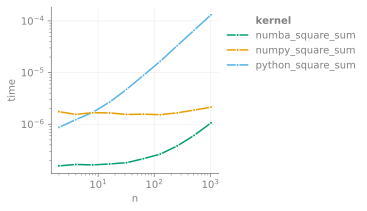

(<Figure size 300x300 with 1 Axes>,
 array([[<Axes: xlabel='n', ylabel='time'>]], dtype=object))

In [12]:
benchmarker.plot()

Under the hood {class}`~xyzpy.Benchmarker` collects and aggregates results
using a {class}`~xyzpy.Harvester`. This means that subsequent runs
of different sizes will be automatically merged. Additionally, if you
initialize the benchmarker with a ``dataname``, the results will be
stored in a on-disk dataset.


## Estimation

### Efficiently collect running statistics

Sometimes it is convenient to collect statistics on-the-fly, rather than storing
all the values and computing statistics afterwards. The
{class}`~xyzpy.RunningStatistics` object can be used for this purpose:

In [13]:
import random

stats = xyz.RunningStatistics()
total = 0.0

# don't know how many `x` we'll generate, and won't keep them
while total < 100:
    x = random.random()
    total += x

    stats.update(x)

We can now check a variety of information about the values generated:

In [14]:
print("             Count: {}".format(stats.count))
print("              Mean: {}".format(stats.mean))
print("          Variance: {}".format(stats.var))
print("Standard Deviation: {}".format(stats.std))
print(" Error on the mean: {}".format(stats.err))
print("    Relative Error: {}".format(stats.rel_err))

             Count: 199
              Mean: 0.5031722149433184
          Variance: 0.08545735406675721
Standard Deviation: 0.2923308982416282
 Error on the mean: 0.020722787940669462
    Relative Error: 0.041184285072266666


For performance, {class}`~xyzpy.RunningStatistics` is a ``numba`` compiled class,
and can also be updated using an iterable very efficiently:

In [15]:
xs = (random.random() for _ in range(10000))

In [16]:
stats.update_from_it(xs)

In [17]:
stats.count

10199

The relative error should now be much smaller:

In [18]:
stats.rel_err

0.0056581110276361585

### Estimating Repeat Quantities

Another common scenario is when you have a function that returns
a noisy estimate, which you would like to estimate to some
relative error. The function {func}`~xyzpy.estimate_from_repeats`
provides this functionality, building on {class}`~xyzpy.RunningStatistics`.

As an example, imagine we want to estimate the sum of ``n`` uniformly distributed
numbers to a relative error of 0.1%:

In [19]:
def rand_n_sum(n):
    return np.random.rand(n).sum()

stats = xyz.estimate_from_repeats(rand_n_sum, n=1000, rtol=0.0001, verbosity=1)

32637it [00:00, 92507.22it/s]


RunningStatistics(mean=4.99971(50)e+02, count=32638)


We can then query the returned ``RunningStatistics`` object:

In [20]:
stats.mean

499.9706134376662

In [21]:
stats.rel_err

0.00010019753062400043

Which looks as expected.